In [39]:
import pandas as pd
import os
import cv2
import numpy as np  
from matplotlib import pyplot as plt
import random

In [22]:
image_patch_size = 256

In [23]:
image = cv2.imread("../DubaiDataset/Tile 1/images/image_part_001.jpg",1)

In [24]:
image.shape # (644,797,3) is (height, width, channels)

(644, 797, 3)

### Read All The Images and Then Crop and Patchify Them

In [25]:
def extract_patches(image, patch_size, stride=None):
    if stride is None:
        stride = patch_size

    h, w = image.shape[:2]
    patches = []

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = image[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return np.array(patches)

In [26]:
dataset_root_folder = '../DubaiDataset'
image_dataset = []
mask_dataset = []
        
for tile_id in range(1, 8):
    img_dir = os.path.join(dataset_root_folder, f"Tile {tile_id}", "images")
    mask_dir = os.path.join(dataset_root_folder, f"Tile {tile_id}", "masks")
    if not os.path.exists(img_dir) or not os.path.exists(mask_dir):
        continue

    for fname in sorted(os.listdir(img_dir)):
        if not fname.endswith(".jpg"):
            continue

        img_path = os.path.join(img_dir, fname)
        mask_path = os.path.join(mask_dir, fname.replace(".jpg", ".png"))

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        if image is None or mask is None:
            continue
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        h, w = image.shape[:2]
        size_x = (w // image_patch_size) * image_patch_size
        size_y = (h // image_patch_size) * image_patch_size

        image = image[0:size_y, 0:size_x]
        mask = mask[0:size_y, 0:size_x]

        image_patches = extract_patches(image, image_patch_size)
        mask_patches = extract_patches(mask, image_patch_size)

        for img_p, msk_p in zip(image_patches, mask_patches):
            image_dataset.append(img_p.astype(np.float32) / 255.0)
            mask_dataset.append(msk_p)


In [30]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [32]:
image_dataset[0].shape

(256, 256, 3)

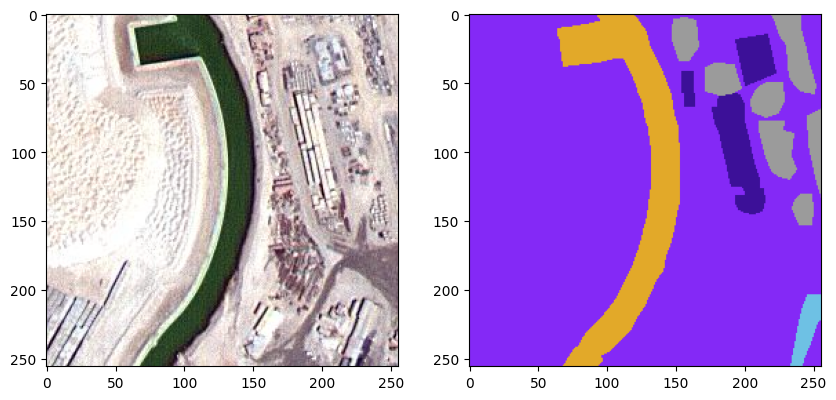

In [37]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[0])
plt.subplot(122)
plt.imshow(mask_dataset[0])

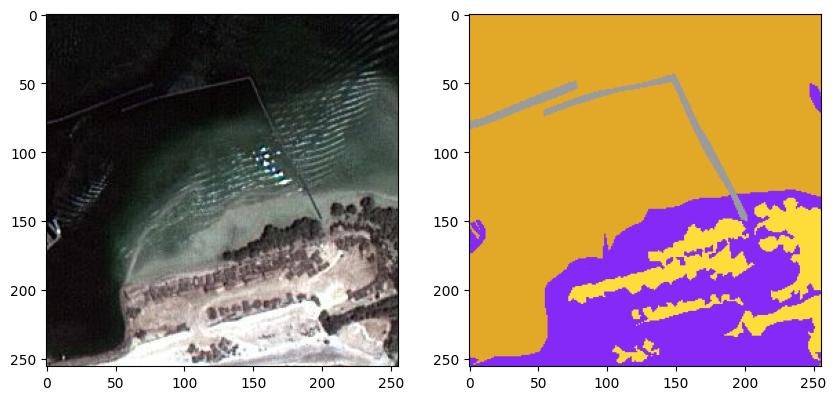

In [44]:
randome_img_id = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[randome_img_id])
plt.subplot(122)
plt.imshow(mask_dataset[randome_img_id])

### Mask Label Processing: One-Hot Encoding

In [46]:
class_building = "3C1098"
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_building

array([ 60,  16, 152])

In [47]:
class_land = "8429F6"
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_land

array([132,  41, 246])

In [48]:
class_road = "6EC1E4"
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_road 

array([110, 193, 228])

In [49]:
class_vegetation = "FEDD3A"
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_vegetation

array([254, 221,  58])

In [50]:
class_water = "E2A929"
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_water

array([226, 169,  41])

In [51]:
class_unlabeled = "9B9B9B"
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0, 2, 4))) # 16-bit because of hex
class_unlabeled

array([155, 155, 155])

In [60]:
def rgb_to_label(label):
    label_segment = np.zeros(label.shape, dtype=np.uint8)
    label_segment[np.all(label == class_water, axis=-1)] = 0
    label_segment[np.all(label == class_land, axis=-1)] = 1
    label_segment[np.all(label == class_road, axis=-1)] = 2
    label_segment[np.all(label == class_building, axis=-1)] = 3
    label_segment[np.all(label == class_vegetation, axis=-1)] = 4
    label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
    label_segment = label_segment[:,:,0]  # Convert to 2D array 
    return label_segment

In [61]:
labels =[]
for i in range(mask_dataset.shape[0]):
    label = rgb_to_label(mask_dataset[i])
    labels.append(label)

In [56]:
labels = np.array(labels)

In [62]:
labels[5]

array([[2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       [2, 2, 2, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [63]:
labels = np.expand_dims(labels,axis = 3)

In [64]:
labels[1]

array([[[1],
        [5],
        [5],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [5],
        [5],
        ...,
        [0],
        [0],
        [0]],

       [[1],
        [1],
        [5],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]],

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]],

       [[1],
        [1],
        [1],
        ...,
        [2],
        [2],
        [2]]], dtype=uint8)

In [65]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

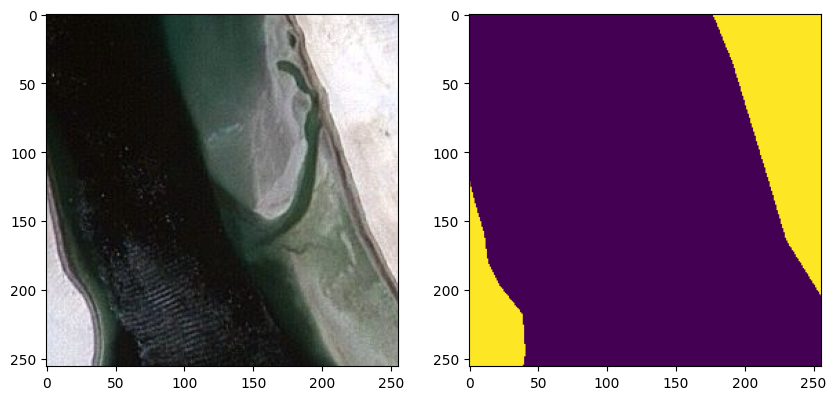

In [70]:
randome_img_id = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(image_dataset[randome_img_id])
plt.subplot(122)
plt.imshow(labels[randome_img_id][:,:,0])   

### Train Test Split Method

In [76]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [77]:
training_data = image_dataset
total_classes = len(np.unique(labels))

labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
X_train, X_test, y_train, y_test = train_test_split(training_data,labels_categorical_dataset, test_size=0.2, random_state=100)

In [78]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(756, 256, 256, 3)
(189, 256, 256, 3)
(756, 256, 256, 6)
(189, 256, 256, 6)
